# Project 2: Ames Housing Predictions

## Problem Statement:

The goal of this project is to optimize a model based on housing data from Ames, IA. The input will be numeric and non-numeric home data that can be used to return an accurate sale price prediction for that home. Accuracy will be judged by RMSE and $R^2$ performance on a test dataset after developing the algorithm with a training dataset. After refining this model, I will identify business insights that can be applied to similar situations.

# NOTEBOOK 01: EDA

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import csv
import pickle

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

%matplotlib inline

In [3]:
df = pd.read_csv('../data/train.csv', index_col='Id')

In [4]:
df.head()

,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


Inital review of dataset

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2051 entries, 109 to 10
Data columns (total 80 columns):
PID                2051 non-null int64
MS SubClass        2051 non-null int64
MS Zoning          2051 non-null object
Lot Frontage       1721 non-null float64
Lot Area           2051 non-null int64
Street             2051 non-null object
Alley              140 non-null object
Lot Shape          2051 non-null object
Land Contour       2051 non-null object
Utilities          2051 non-null object
Lot Config         2051 non-null object
Land Slope         2051 non-null object
Neighborhood       2051 non-null object
Condition 1        2051 non-null object
Condition 2        2051 non-null object
Bldg Type          2051 non-null object
House Style        2051 non-null object
Overall Qual       2051 non-null int64
Overall Cond       2051 non-null int64
Year Built         2051 non-null int64
Year Remod/Add     2051 non-null int64
Roof Style         2051 non-null object
Roof Matl          2

From the .info() output we know that we have 2051 rows x 81 columns of numeric and non-numeric data. It appears that there are missing values in many of the features. The isnull() method will be used below to get an accurate count of null values for each column. Depending on the feature represented, null values will either be excluded for a single observation/full feature, replaced by 0, or inferred/replaced as needed.

Observations:
- Land Contour and Land Slope may be highly correlated.
- Lot Shape may not have much bearing on our model. Possibly extraneous.
- Garage Qual and Garage Cond likely redundant.
- For Functional, should review count of unique values for any outlier types. Likely that some categories are underrepresented and don't encode enough signal to be useful. 
- Bsmt Full Bath and Bsmt Half Bath / Full Bath and Half Bath can probably be combined to create Bsmt Baths and Baths.

We will review the data dictionary to gain a more clear understanding of how these features are encoded with an eye toward identifying possible colinearities.


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
PID,2051.0,7.135900e+08,1.886918e+08,526301100.0,528458140.0,535453200.0,9.071801e+08,924152030.0
MS SubClass,2051.0,5.700878e+01,4.282422e+01,20.0,20.0,50.0,7.000000e+01,190.0
Lot Frontage,1721.0,6.905520e+01,2.326065e+01,21.0,58.0,68.0,8.000000e+01,313.0
Lot Area,2051.0,1.006521e+04,6.742489e+03,1300.0,7500.0,9430.0,1.151350e+04,159000.0
Overall Qual,2051.0,6.112140e+00,1.426271e+00,1.0,5.0,6.0,7.000000e+00,10.0
Overall Cond,2051.0,5.562165e+00,1.104497e+00,1.0,5.0,5.0,6.000000e+00,9.0
Year Built,2051.0,1.971709e+03,3.017789e+01,1872.0,1953.5,1974.0,2.001000e+03,2010.0
Year Remod/Add,2051.0,1.984190e+03,2.103625e+01,1950.0,1964.5,1993.0,2.004000e+03,2010.0
Mas Vnr Area,2029.0,9.969591e+01,1.749631e+02,0.0,0.0,0.0,1.610000e+02,1600.0
BsmtFin SF 1,2050.0,4.423005e+02,4.612041e+02,0.0,0.0,368.0,7.337500e+02,5644.0


Observations:
- PID can be dropped as it won't be usful for a linear regression model. PID is a unique identifier that has no bearing on home price. 
- Lot Area may have an outlier as the max value is very large for a parcel. 
- Garage Yr Blt may be strongly correlated to Year Built, can likely be eliminated as redundant.
- Garage Yr Blt has a max value of 2207, likely an error.
- Garage Area and Garage Cars is likely highly correlated. 1 feature can probably be eliminated as redundant. 
- Enclosed Porch, 3Ssn Porch, and Screen Porch are likely similar.
- BsmtFin SF 1 + BsmtFin SF 2 + Bsmt Unf SF presumably = Total Bsmt SF. Can likely be consolidated into BsmtFin (BsmtFin SF1 + BsmtFin SF2) and Total Bsmt SF.
- 1st Flr SF + 2nd Flr SF presumably = Gr Liv Area. Can likely drop 1st Flr SF & 2nd Flr SF since it's already represented by Gr Liv Area.
- BsmtFin SF 1 + BsmtFin SF 2 + Gr Liv Area presumably = Low Qual Fin SF. Can probably be eliminated if keeping BsmtFin & Gr Liv Area.
- The min for SalePrice is extreamly low and should be investigated further. Likely outlier that is not representative of most homes.

In [7]:
df.isnull().sum().sort_values(ascending=False)

Pool QC            2042
Misc Feature       1986
Alley              1911
Fence              1651
Fireplace Qu       1000
Lot Frontage        330
Garage Qual         114
Garage Finish       114
Garage Cond         114
Garage Yr Blt       114
Garage Type         113
Bsmt Exposure        58
BsmtFin Type 2       56
Bsmt Cond            55
Bsmt Qual            55
BsmtFin Type 1       55
Mas Vnr Type         22
Mas Vnr Area         22
Bsmt Half Bath        2
Bsmt Full Bath        2
Garage Cars           1
Garage Area           1
Total Bsmt SF         1
Bsmt Unf SF           1
BsmtFin SF 2          1
BsmtFin SF 1          1
Year Built            0
Exterior 2nd          0
Exterior 1st          0
Roof Matl             0
                   ... 
Exter Qual            0
Heating               0
Foundation            0
Sale Type             0
Yr Sold               0
Mo Sold               0
Misc Val              0
Pool Area             0
Screen Porch          0
3Ssn Porch            0
Enclosed Porch  

Analyzing the number of null values for each feature.

Observations:

- Pool QC: The data dictionary states that homes with no pool are represented by NaN. Since this feature only represents 9 observations there will not be enough signal to meaningfully contribute to our model. Will drop this feature.

- Misc Feature: The data dictionary states that homes with no misc feature are represented by NaN. Since this feature encodes data that may significantly impact home price and is colinear with Misc Val we will encode NaNs as 0 for a new binary category and fill NaNs here with 'none' value.

- Alley: The data dictionary states that homes with no alley access are represented by NaN. Converting to 'none' since this is the only category that encodes this information. ~4% of our observations are represented by this feature.

- Fence: The data dictionary states that homes with no fence are represented by NaN. Converting to 'none' since this is the only feature encoding this information. ~25% of the dataset is represented by this feature.

- Fireplace Qu: The data dictionary states that homes with no fireplace are represented by NaN. Since this is colinear with Fireplaces and homes without a fireplace are already encoded we will fill NaNs with 'none'. ~50% of the dataset is represented by this feature. 

- Lot Frontage: Likely that NaNs represent homes with no frontage access. We will replace with 0.0 since this feature represents ~85% of the dataset.

- Garage Cond / Garage Qual / Garage Yr Blt / Garage Finish / Garage Type: The data dictionary states that homes with no garage are represented by NaN. There should be the same number of NaNs for all features. Can replace with 'none' or 0 depending on feature type since homes with no garage are encoded by Garage Cars = 0. 

- Bsmt Exposure / BsmtFin Type 2 / Bsmt Qual / BsmtFin Type 1 / Bsmt Cond: The data dictionary states that homes with no garage are represented by NaN. There should be the same number of NaNs for all features. Can replace with 'none' since all features are categorical.

- Mas Vnr Type / Mas Vnr Area: Likely that the NaNs for these features overlap and represent homes without a vaneer. We will create a binary column representing existance of a vaneer.

- Bsmt Half Bath / Bsmt Full Bath: Likely that the Nans for these features overlap and represent homes with no basement bathroom or a data entry error. Can consolidate into one discrete numeric feature for Bsmt Bath.

- Bsmt Unf SF / Total Bsmt SF / BsmtFin SF 1 /BsmtFin SF 2: Likely that the Nans for these features overlap and represent data entry errors. Can consolidate into a single continuous category encoding Total Bsmnt SF.

- Garage Cars / Garage Area: Likely that the NaNs for these features overlap and represent a data entry error.




# Exploratory Visualizations
Reviewing correlations and distributions to identify features of interest for data cleaning and feature engineering.

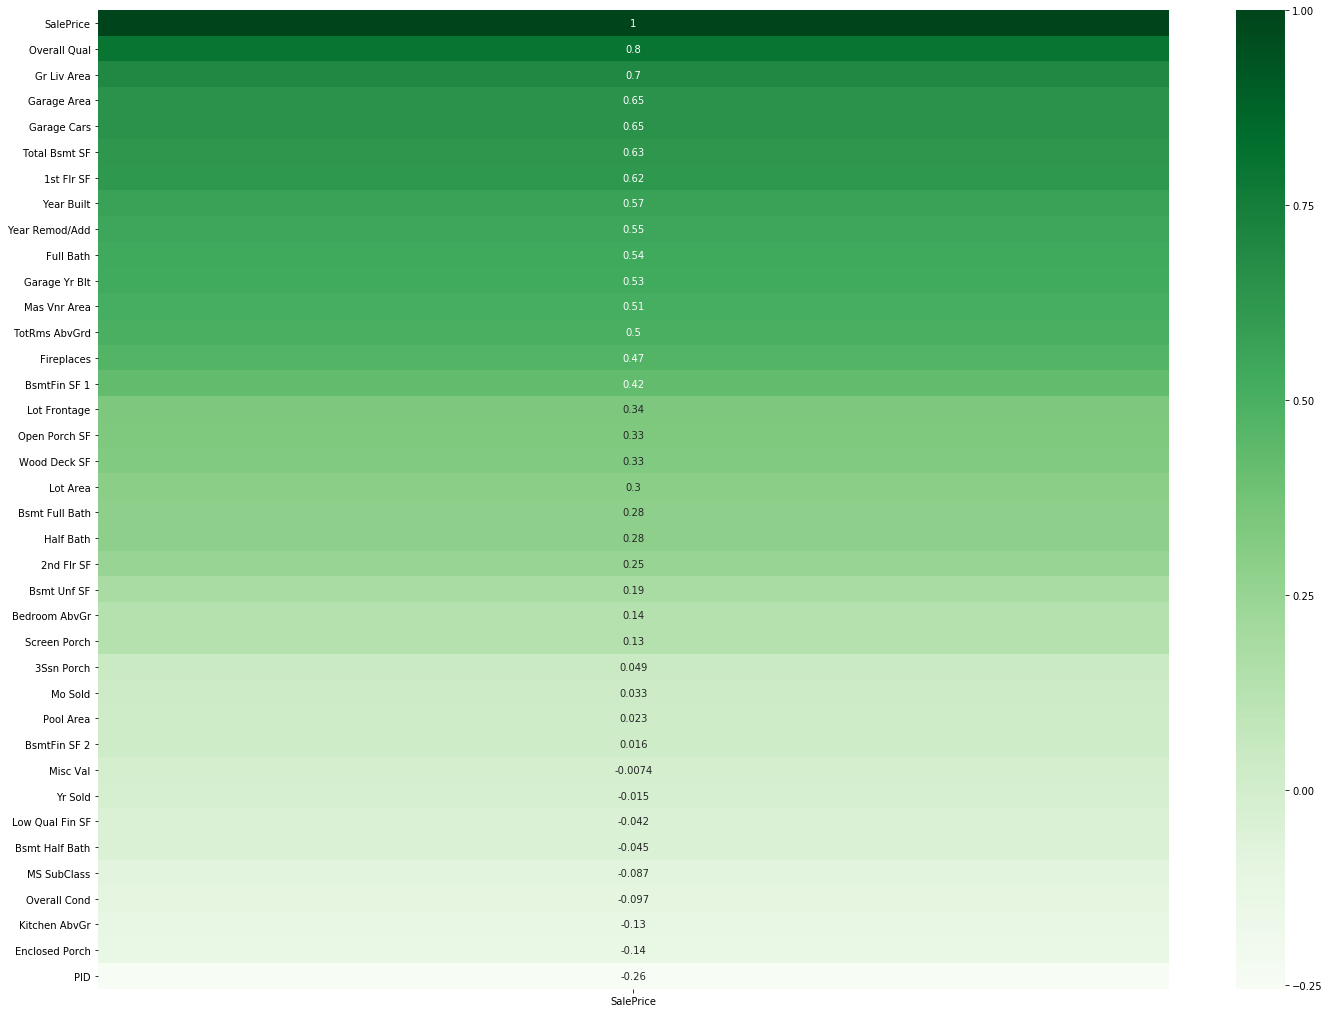

In [8]:
plt.figure(figsize=(24, 18))
sns.heatmap(df.corr()[['SalePrice']].sort_values(['SalePrice'],ascending =False), annot=True, cmap = 'Greens');

SalePrice shows the highest correlation with Overall Qual, Gr Liv Area, Garage Area, Garage Cars, Total Bsmt SF, 1st Flr SF, Year Built, Year Remod/Add, Baths, Garage Yr Blt, Mas Vnr Area, TotRms AbvGrd, Fireplaces, & BsmtFin SF 1. 

Possible Colinearities:
- Garage Area / Garage Cars
- Total Bsmt SF / 1st Flr SF / BsmtFin SF 1 
- Baths / Gr Liv Area / TotRms AbvGrd 
- Year Built / Garage Yr Blt

We will review further with a heatmap and individual plots.

In [14]:
high_corr=df[['Overall Qual',
              'Gr Liv Area',
              'Garage Area',
              'Garage Cars',
              'Total Bsmt SF',
              '1st Flr SF',
              'Year Built',
              'Year Remod/Add',
              'Full Bath',
              'Garage Yr Blt',
              'Mas Vnr Area',
              'TotRms AbvGrd',
              'Fireplaces',
              'BsmtFin SF 1',
              'SalePrice']]

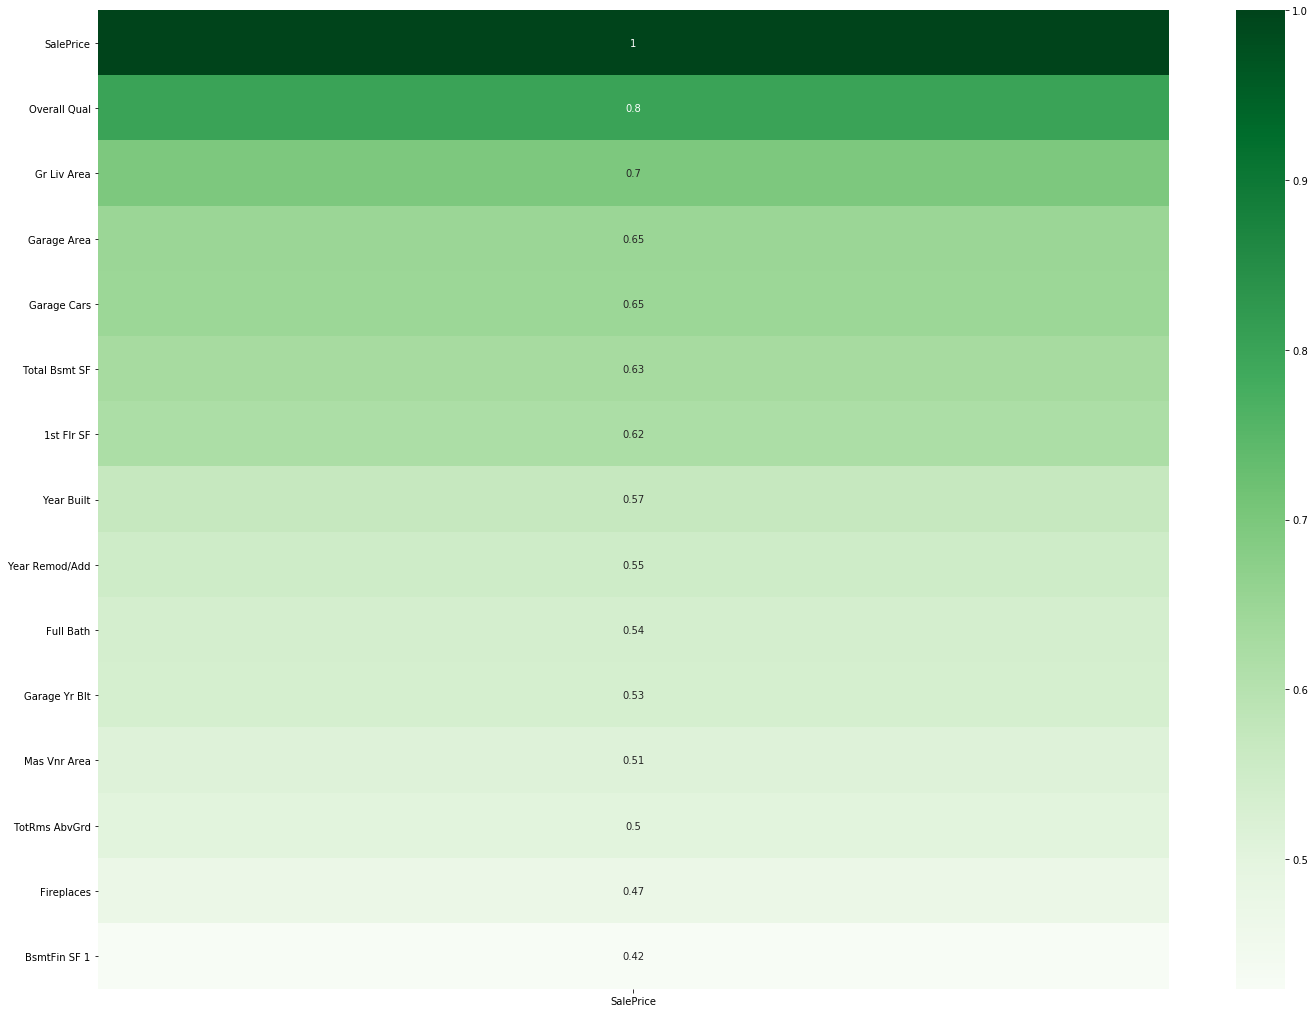

In [15]:
plt.figure(figsize=(24, 18))
sns.heatmap(high_corr.corr()[['SalePrice']].sort_values(['SalePrice'],ascending =False), annot=True, cmap = 'Greens');

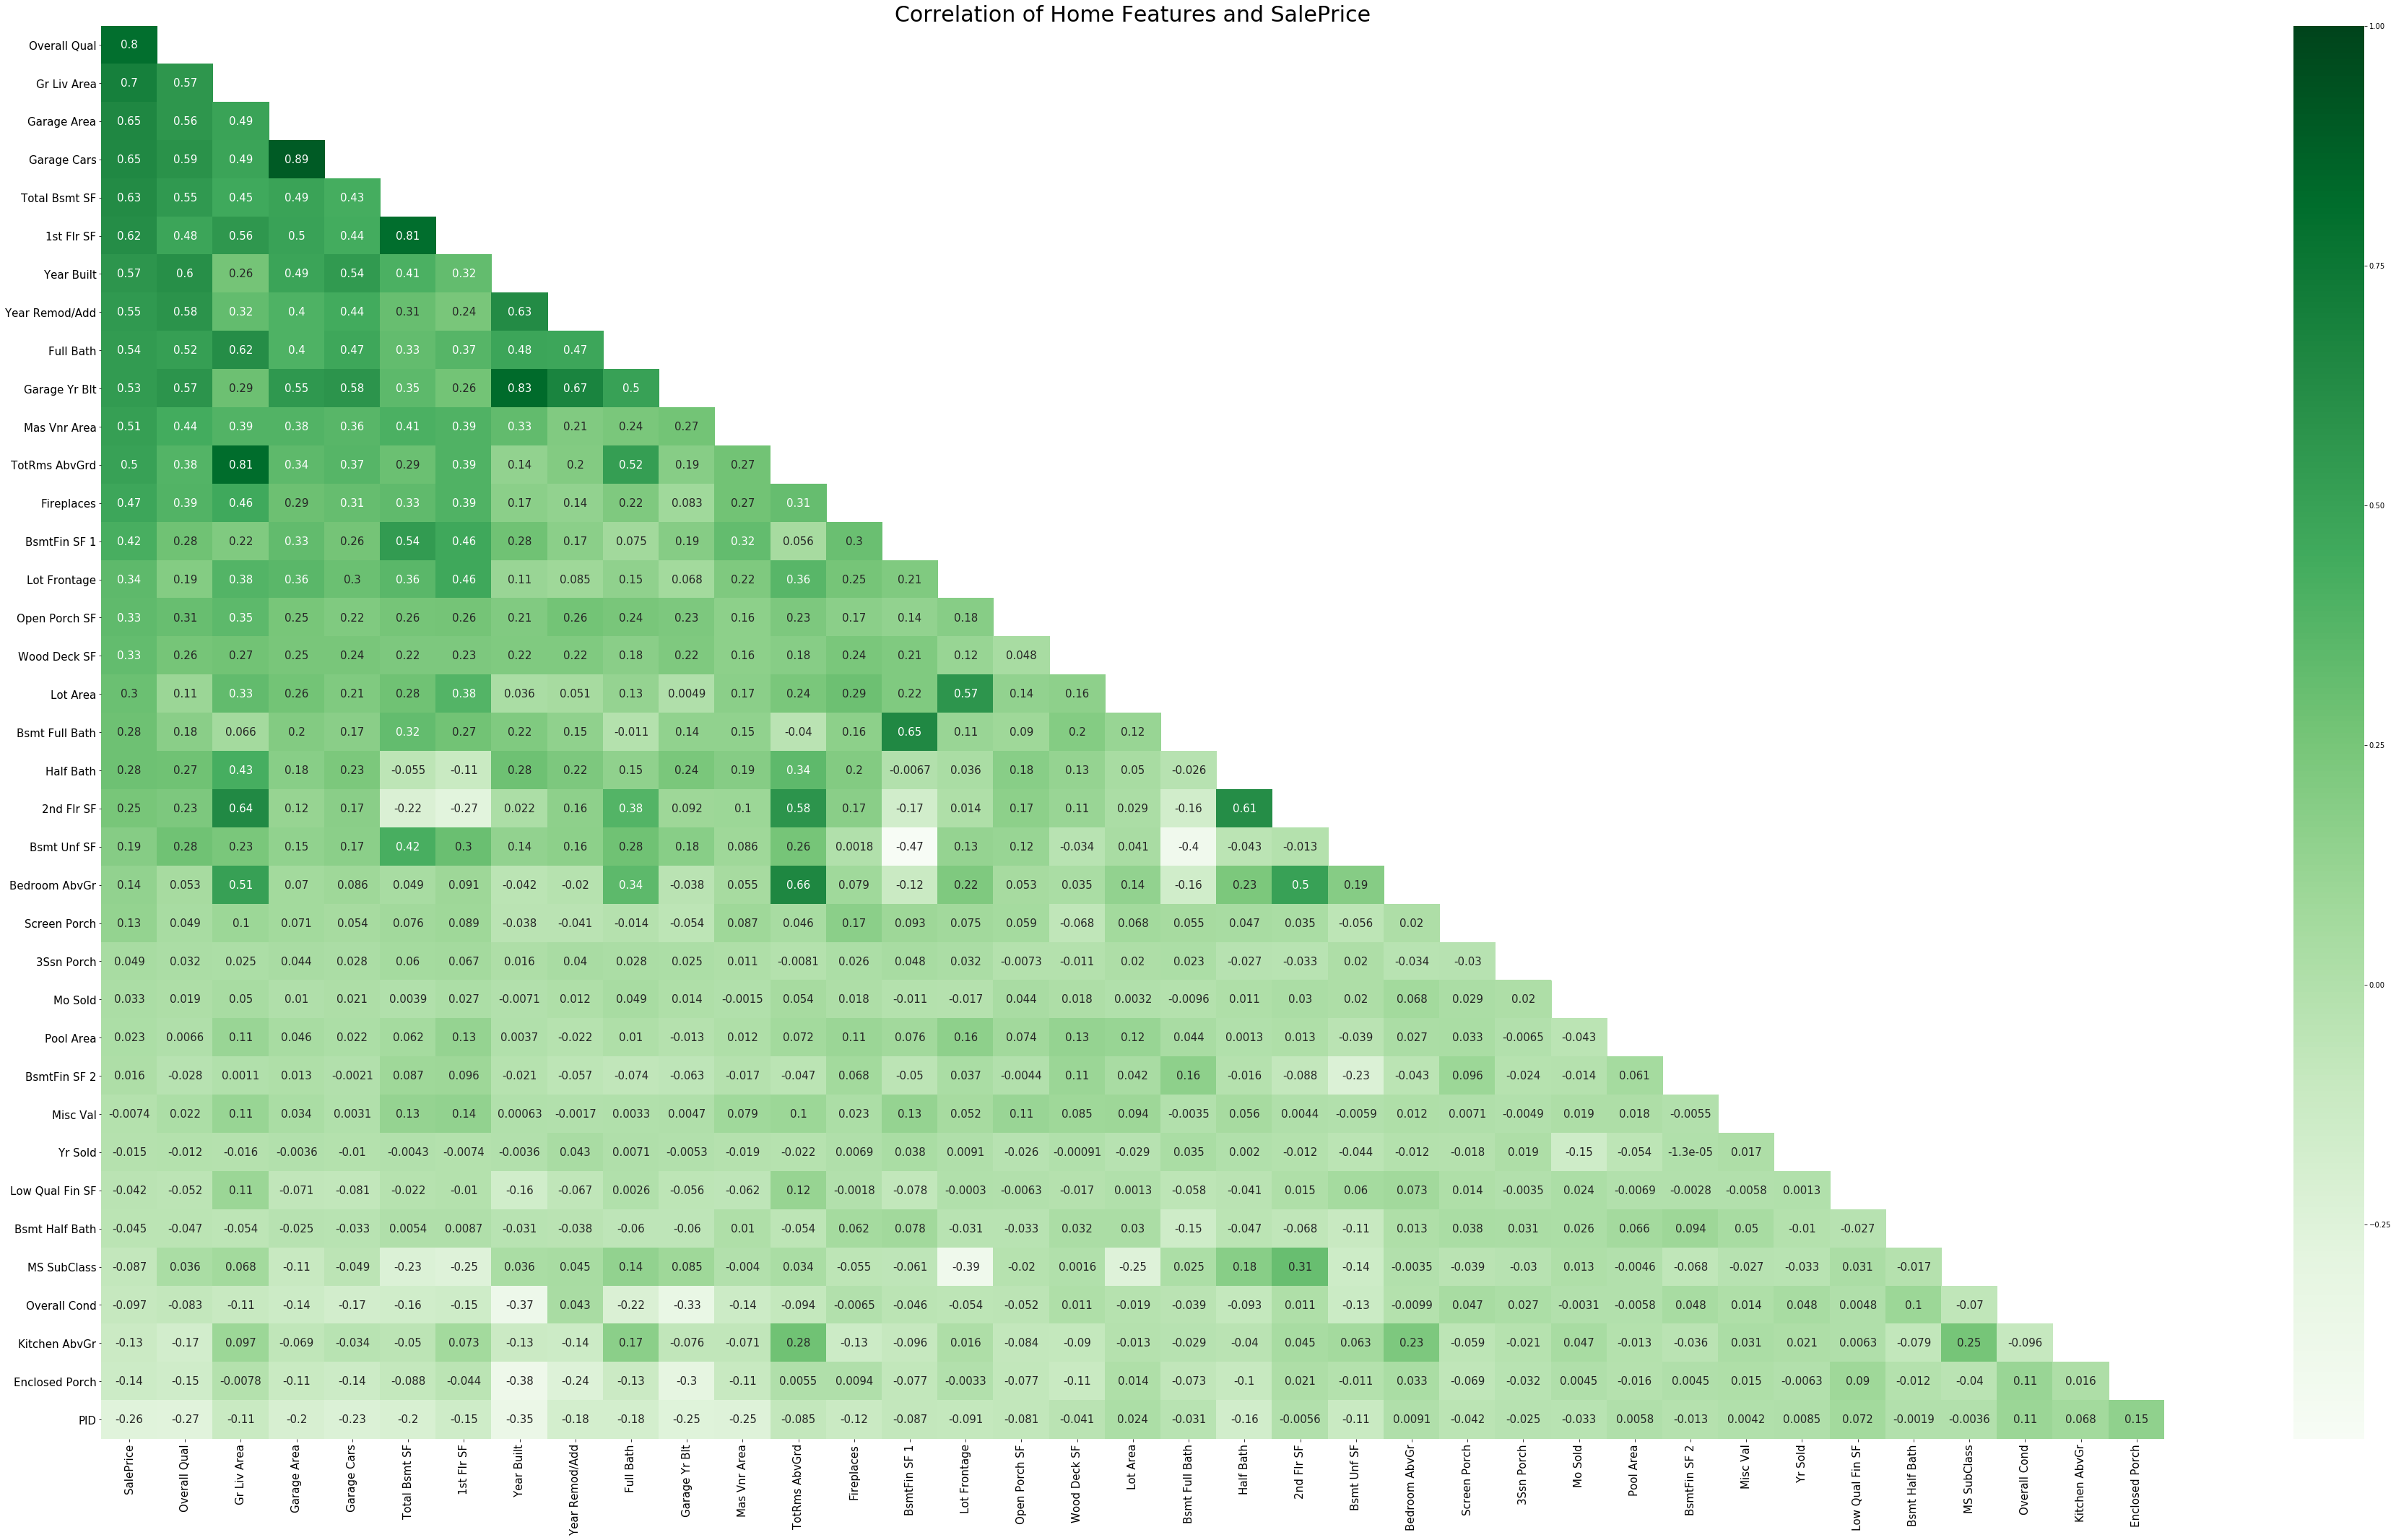

In [8]:
plt.figure(figsize=(64,36))
mask = np.triu(np.ones_like(df.corr()))

col_order = df.corr().sort_values('SalePrice', ascending=False).index
ax = sns.heatmap(df[col_order].corr(), 
                 annot=True, 
                 annot_kws={"size":15}, 
                 mask=mask,
                 cmap='Greens')
ax.set_title('Correlation of Home Features and SalePrice', fontsize=30)
ax.tick_params(axis='x', labelsize=15, labelrotation=90);
ax.tick_params(axis='y', labelsize=15, labelrotation=0);
y_min, y_max = ax.get_ylim();
x_min, x_max = ax.get_xlim();
ax.set_ylim(top=y_max+1);
ax.set_xlim(right=x_max-1);

The correlation heatmap will help identify other highly correlated numeric features. 

Notable correlations are:
- Gr Liv Area / TotRms AbvGrd
- Garage Area / Garage Cars
- Total Bsmt SF / 1st Flr SF
- Year Built / Garage Yr Blt / Year Remod/Add
- Full Bath / TotRms AbvGrd
- TotRms AbvGrd / Bedroom AbvGr / 2nd Flr SF
- BsmtFin SF 1 / Bsmt Baths
- Lot Frontage / Lot Area
- Half Bath / 2nd Flr SF
- 2nd Flr SF / Bedroom AbvGr

These will be investigated more thoroughly with scatter plots.

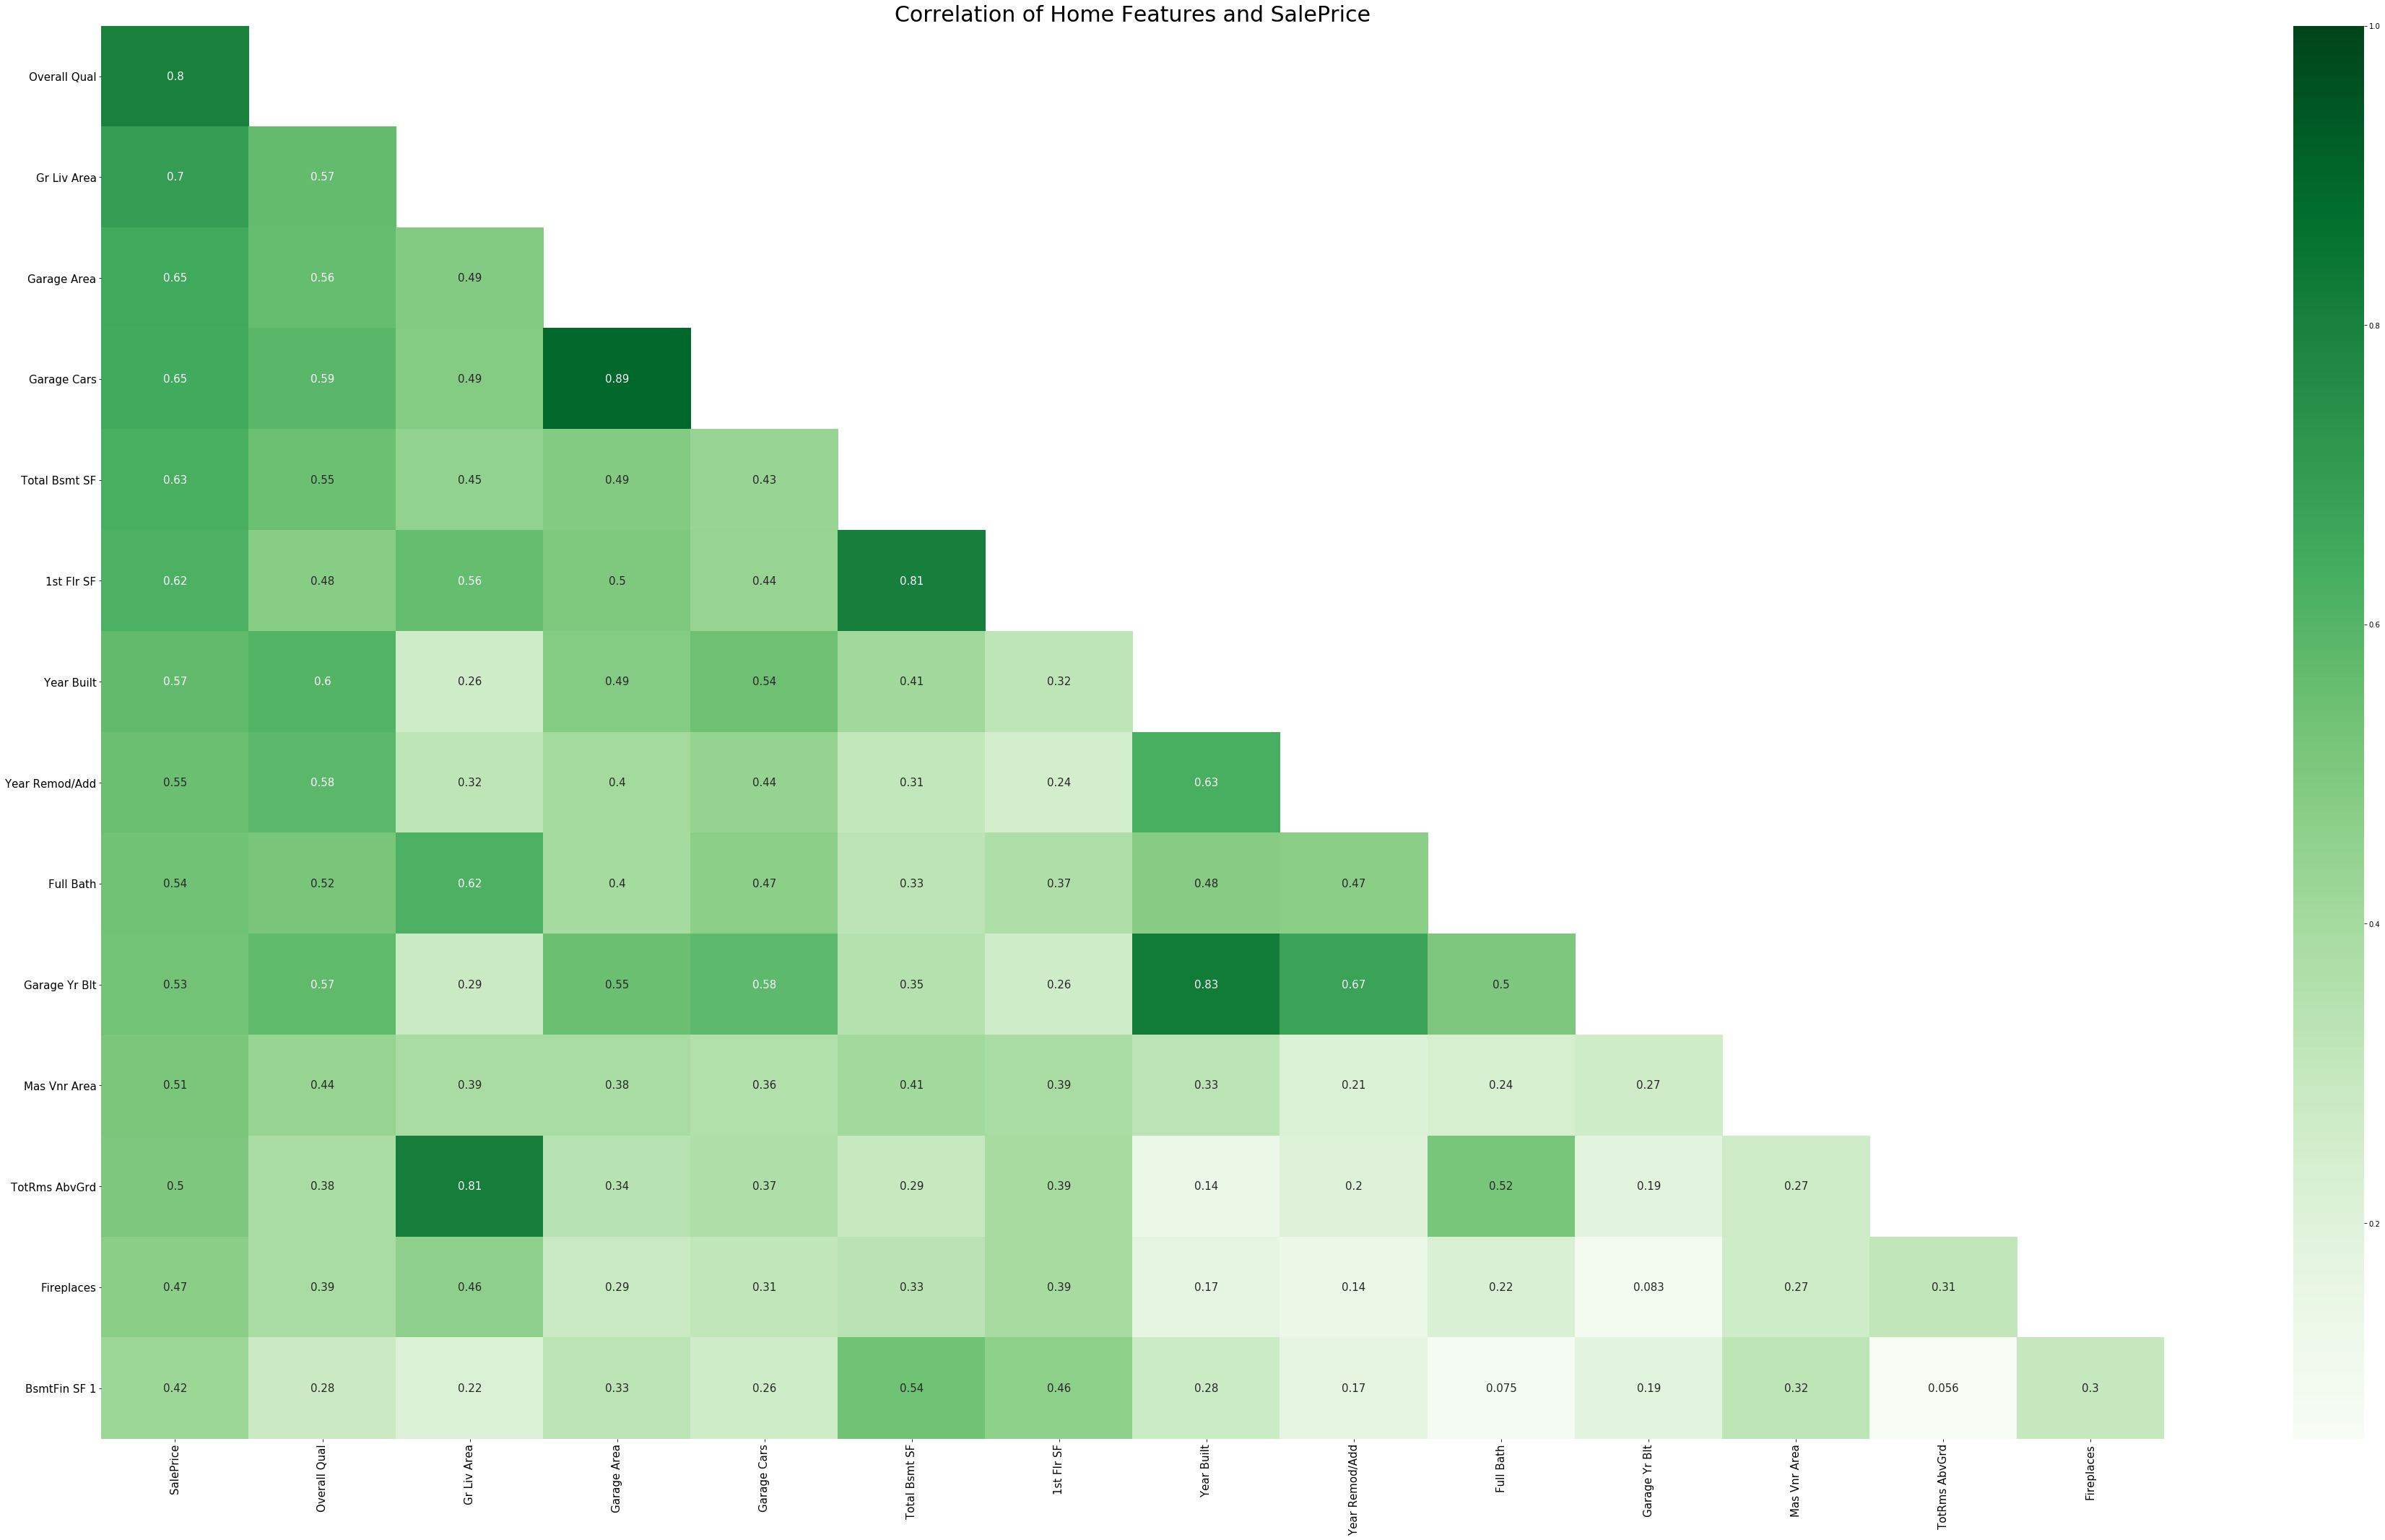

In [16]:
plt.figure(figsize=(64,36))
mask = np.triu(np.ones_like(high_corr.corr()))

col_order = high_corr.corr().sort_values('SalePrice', ascending=False).index
ax = sns.heatmap(high_corr[col_order].corr(), 
                 annot=True, 
                 annot_kws={"size":15}, 
                 mask=mask,
                 cmap='Greens')
ax.set_title('Correlation of Home Features and SalePrice', fontsize=30)
ax.tick_params(axis='x', labelsize=15, labelrotation=90);
ax.tick_params(axis='y', labelsize=15, labelrotation=0);
y_min, y_max = ax.get_ylim();
x_min, x_max = ax.get_xlim();
ax.set_ylim(top=y_max+1);
ax.set_xlim(right=x_max-1);

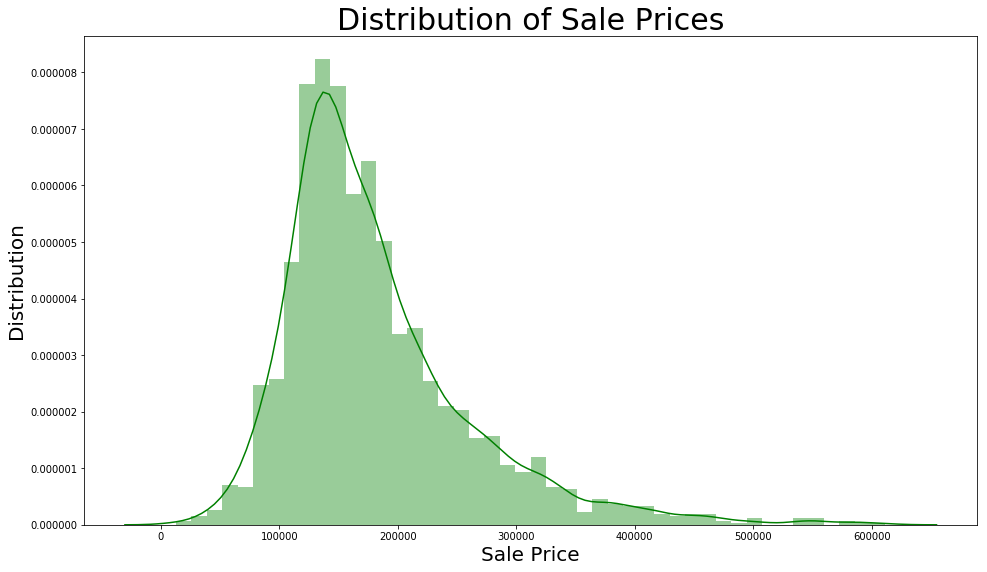

In [9]:
plt.figure(figsize=(16,9))

sns.distplot(df['SalePrice'], color = 'green')

plt.xlabel('Sale Price', fontsize=20)
plt.ylabel('Distribution', fontsize=20)
plt.title('Distribution of Sale Prices', fontsize=30);

The distribution of sale prices is positively skewed and does not follow a normal distribution. 

In [10]:
def subplot_scatter(df, feat_dict, ncols=2):
    nrows=int(np.ceil(len(feat_dict)/2))
    fig, ax = plt.subplots(nrows, ncols, figsize = (20,(5*nrows)))
    ax = ax.ravel()
    i=0
    
    for key, value in feat_dict.items():
        sns.scatterplot(df[key], df[value], ax=ax[i], color = 'green')
        ax[i].set_xlabel(key, fontsize = 20)
        ax[i].set_ylabel(value,fontsize = 20)
        ax[i].set_title(f'Relationship Between {key} and {value}', fontsize=25)
        i += 1
        
    plt.tight_layout()

Created a subplot scattering function for comparing numerical features and implementing below to compare highly correlated features against SalePrice.

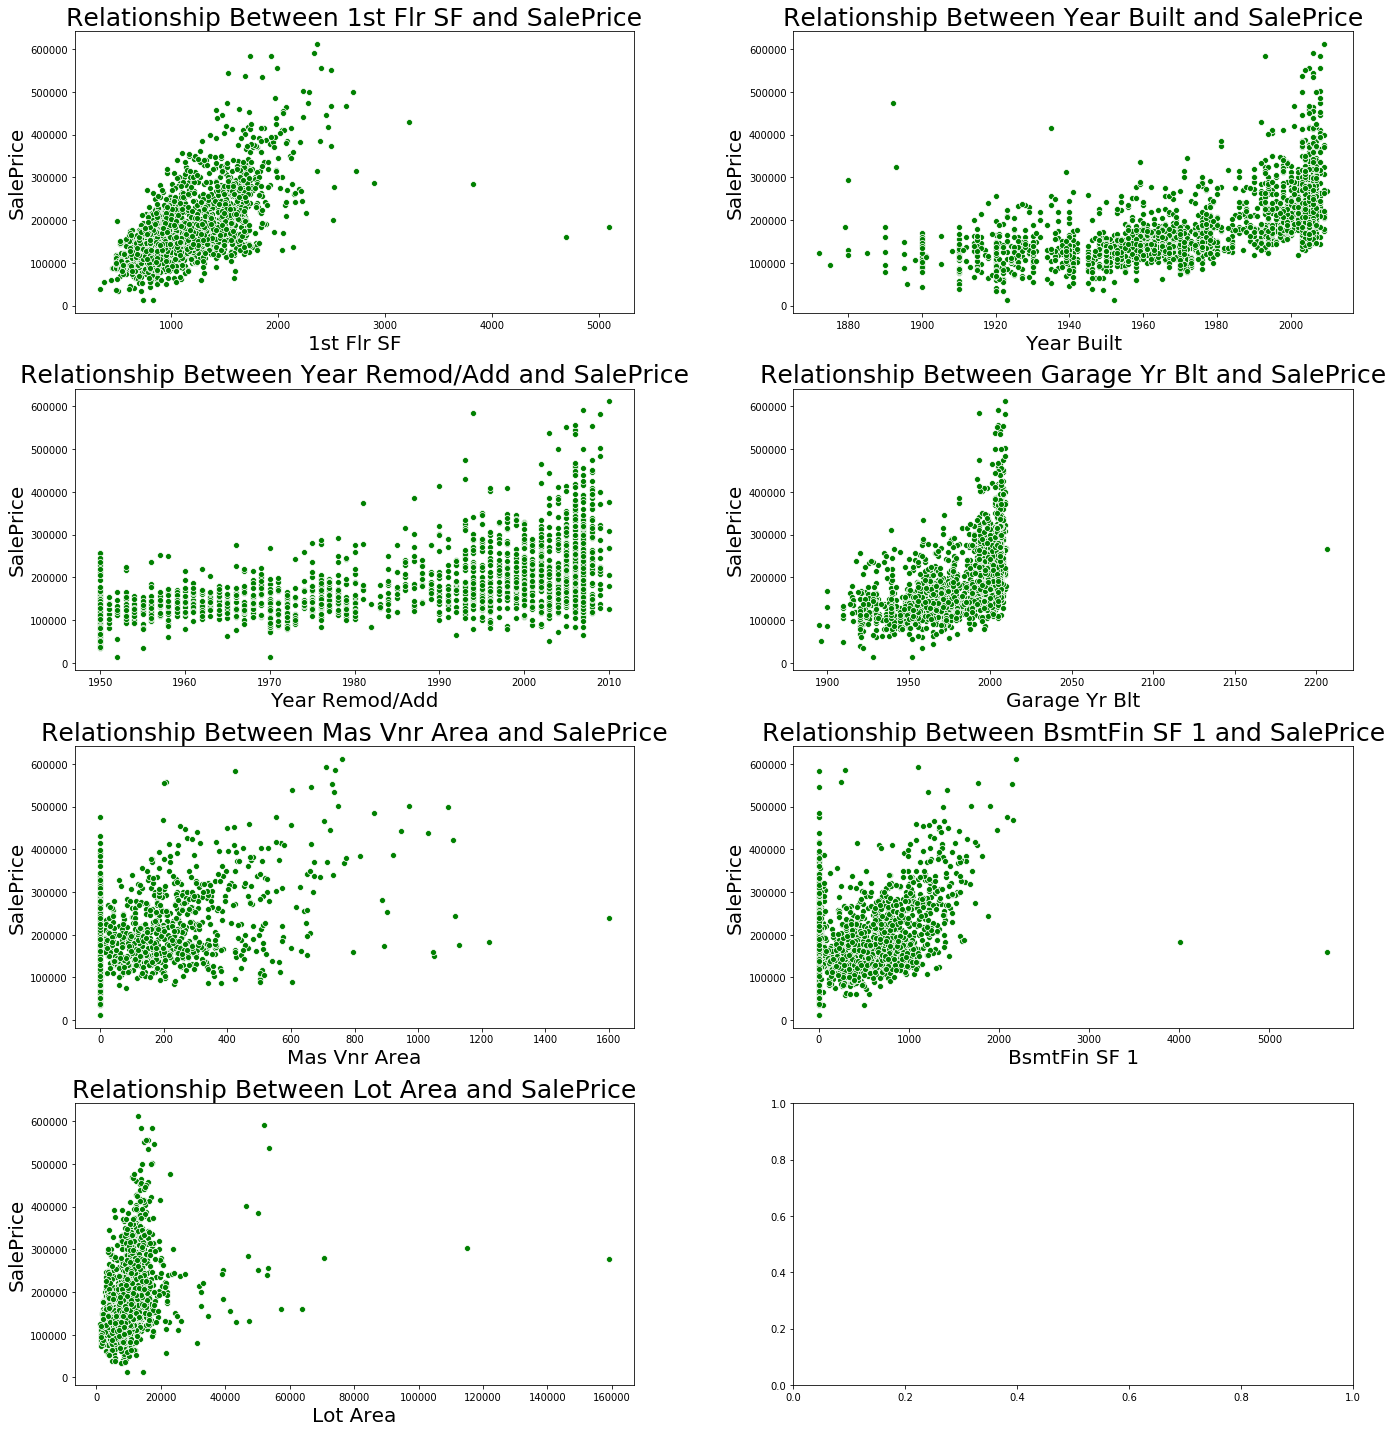

In [11]:
feat_dict={
    '1st Flr SF':'SalePrice',
    'Year Built':'SalePrice',
    'Year Remod/Add':'SalePrice', 
    'Garage Yr Blt':'SalePrice',
    'Mas Vnr Area':'SalePrice',
    'BsmtFin SF 1':'SalePrice',
    'Lot Area':'SalePrice',
}

subplot_scatter(df, feat_dict, ncols=2)

Observations:

- 1st Flr SF: Strong linear relationship with the exception of 3 outliers. Slight heteroskedasticity

- Year Built: Can be well approximated by a linear funcation but may be modeled more accurately with a higher order function.

- Year Remod/Add: Well defined linear relationship with slight heteroskedasticity with more recent observations

- Garage Yr Blt: Can be well approximated by a linear function but may be modeled more accurately with a higher order function.

- Mas Vnr Area: Can be modeled with a linear function. Outlier at 1600 likely not significant due to high variance across all values. 

- BsmtFinSF 1: Strong linear relationship with outliers at 4000 and 5700. Predicted impact is minimal since there is high variance at larger values. Will replot without outliers for more clear analysis.

- Lot Area: Very strong linear relationship from 0-20000 with outliers at 110000 and 160000. SHould remove since these are huge outliers.

In [12]:
df['Lot Area'].sort_values(ascending=False).head()

Id
2116    159000
2072    115149
2767     70761
1499     63887
315      57200
Name: Lot Area, dtype: int64

In [13]:
df.loc[(2116, 2072),('Lot Area', 'SalePrice')]

,Lot Area,SalePrice
Id,,
2116,159000,277000
2072,115149,302000


In [14]:
df.drop([2116,2072], axis=0, inplace=True)

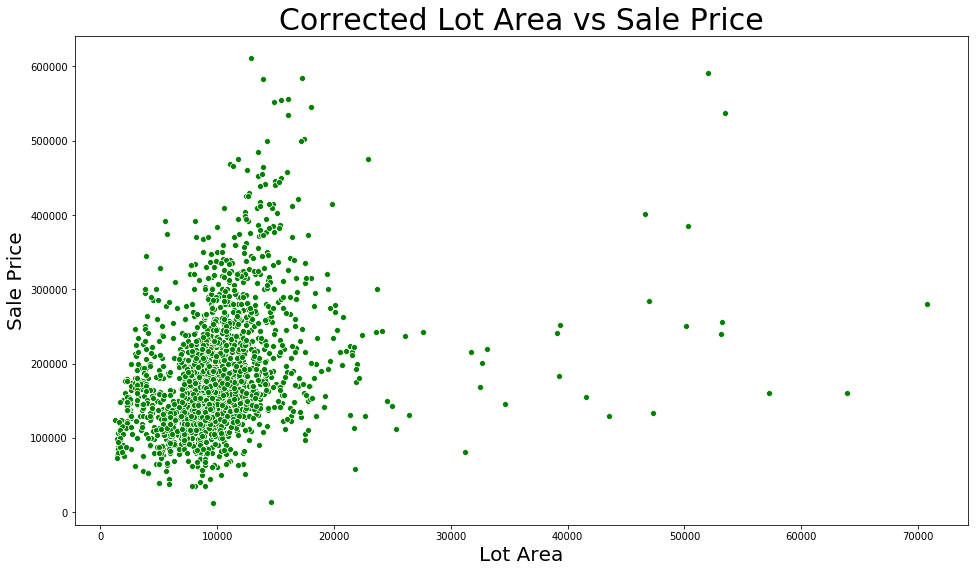

In [15]:
plt.figure(figsize=(16,9))
sns.scatterplot(df['Lot Area'], df['SalePrice'], color='g')

plt.xlabel('Lot Area', fontsize=20)
plt.ylabel('Sale Price', fontsize=20)
plt.title('Corrected Lot Area vs Sale Price', fontsize=30);

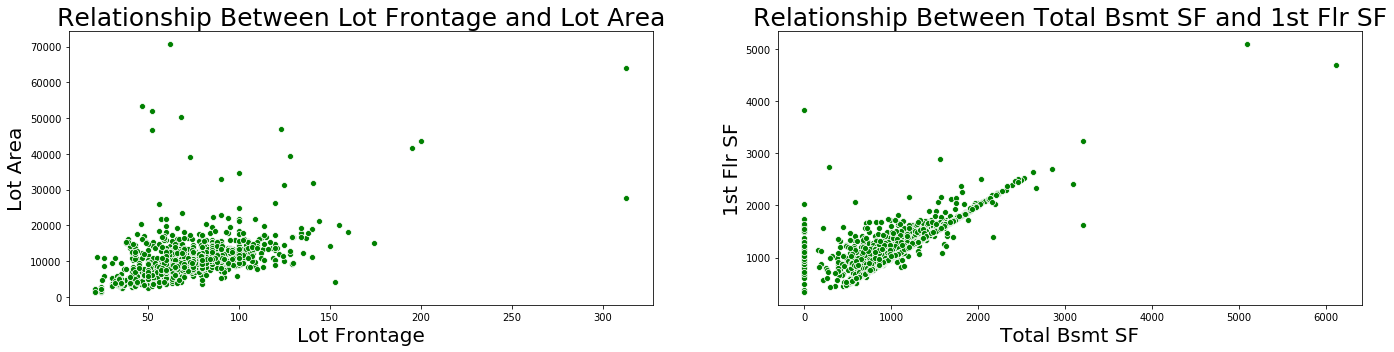

In [16]:
feat_dict = {
    'Lot Frontage':'Lot Area',
    'Total Bsmt SF':'1st Flr SF'
}

subplot_scatter(df, feat_dict, ncols=2)

In [17]:
(df['Year Built'] != df['Garage Yr Blt']).sum()/2051

0.23744514870794733

About ~24% of observations do not align. Will likely need to keep or convert if Garage Yr Blt shows meaningful contribution to home value

Plotting correlated continuous features to identify colinearity.

Observations:

- Lot Frontage / Lot Area: Strong linear relationship with few significant outliers. May consider dropping one feature or creating interaction term.

- Total Bsmt SF / 1st Flr SF: Strong linear relationship which is not surprising considering how homes are built. Will consider using only one of these features since they are very colinear.

Replotting features with outliers excluded for better visualization.

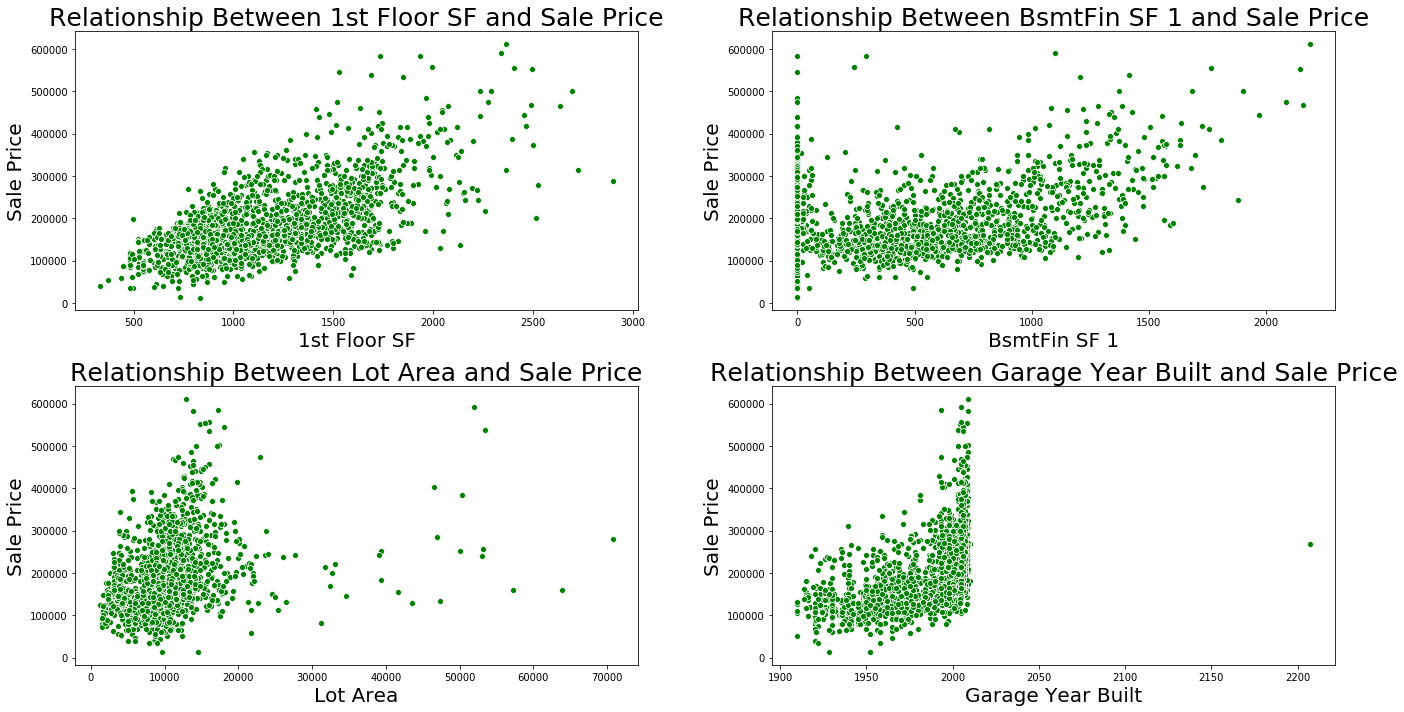

In [18]:
first = df['1st Flr SF'][df['1st Flr SF'] < 3000]
second = df['BsmtFin SF 1'][df['BsmtFin SF 1'] < 3000]
third = df['Lot Area'][df['Lot Area'] < 80000]
fourth = df['Garage Yr Blt'][df['Garage Yr Blt'] > 1900]
x_labels = ['1st Floor SF','BsmtFin SF 1','Lot Area','Garage Year Built']
x_list = [first,second,third,fourth]

nrows=int(np.ceil(len(x_list)/2))
fig, ax = plt.subplots(nrows, 2, figsize = (20,(5*nrows)))
ax = ax.ravel()
    
for i, x in enumerate(x_list):
    sns.scatterplot(x, df['SalePrice'], ax=ax[i], color = 'green')
    ax[i].set_xlabel(x_labels[i], fontsize = 20)
    ax[i].set_ylabel('Sale Price',fontsize = 20)
    ax[i].set_title(f'Relationship Between {x_labels[i]} and Sale Price', fontsize=25)
    
plt.tight_layout()

Easier to visualize relationships with outliers excluded. Strong correlation across all four features.

Defining boxplot subplotting function for comparison of categorical features with SalePrice. Implemented below with features thought to have impact on home value.

In [19]:
def subplot_boxplot(df, feat_dict, ncols=2):
    nrows=int(np.ceil(len(feat_dict)/2))
    fig, ax = plt.subplots(nrows, ncols, figsize = (20,(5*nrows)))
    ax = ax.ravel()
    i=0
    
    for key,value in feat_dict.items():
        sns.boxplot(df[key], df[value], ax=ax[i], color = 'green')
        ax[i].set_xlabel(key, fontsize = 20)
        ax[i].set_ylabel(value,fontsize = 20)
        ax[i].set_title(f'Relationship Between {key} and {value}', fontsize=25)
        i += 1
        
    plt.tight_layout()

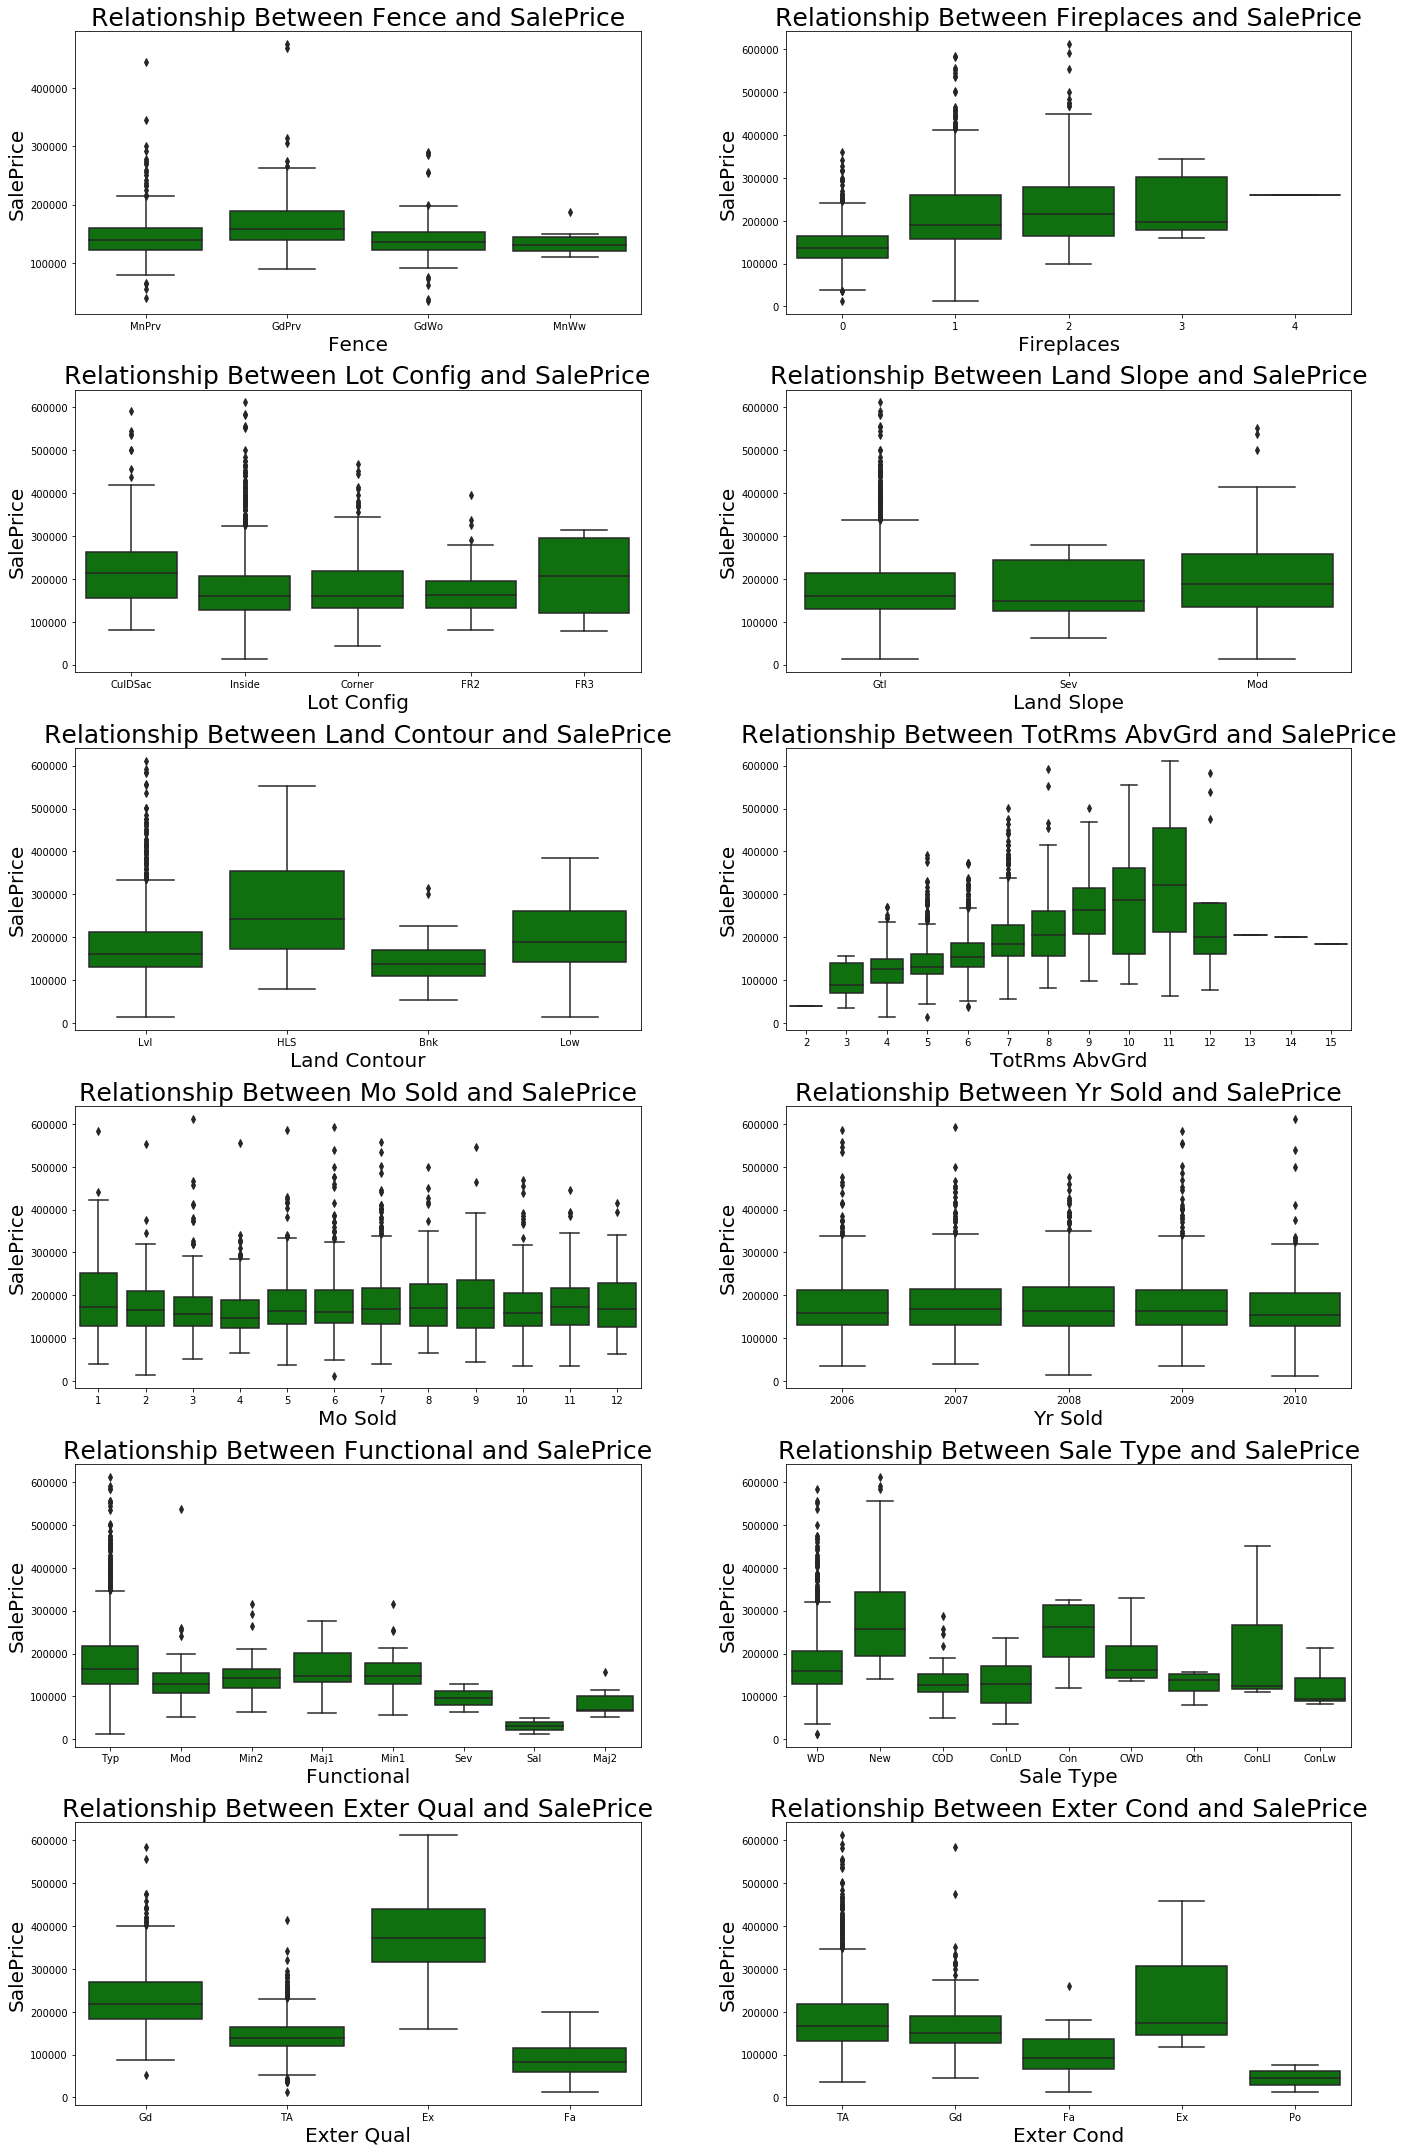

In [20]:
feat_dict={
    'Fence':'SalePrice',
    'Fireplaces':'SalePrice',
    'Lot Config':'SalePrice',
    'Land Slope':'SalePrice',
    'Land Contour':'SalePrice',
    'TotRms AbvGrd':'SalePrice',
    'Mo Sold':'SalePrice',
    'Yr Sold' :'SalePrice',
    'Functional':'SalePrice',
    'Sale Type':'SalePrice',
    'Exter Qual':'SalePrice',
    'Exter Cond':'SalePrice',
}

subplot_boxplot(df, feat_dict, ncols=2)

All features show a large number of outliers for the predominant category. This means these features are likely poor predictors of SalePrice, though they may significantly contribute to overall home value if significant variation is seen between categories.

Observations:

- Fence: Low variance and consistent effect on price across all categories. Many outliers for minimum privacy (MnPrv). Likely not a good predictor of SalePrice since this only represents ~25% of homes but may contribute to home value.

- Fireplaces: There appears to be a positive linear relationship between number of fireplaces and SalePrice. Many outliers but only ~80k in price variation. Few observations for homes with 4 fireplaces. 

- Lot Config: Seems to have a strong impact on home value. Cul de Sacs seem to be more highly valued than other configurations. Many outliers for Inside configuration. Highest ICR on homes with frontage on 3 sides (FR3). May be good predictor of home value.

- Land Slope: Seems to have impact on home value but also has a wide IQR. Many outliers for Gentle (Gtl) category.

- Land Contour: Seems to have strong impact home value. Very high variance in Level (Lvl) category.  Banked (Bnk) may have a negative effect since it is right around the mean home value. 

- TotRms AbvGrd: Strong relationship between number of rooms and SalePrice. Homes with 13+ rooms are not well defined since there are too few observations. 

- Mo Sold: Seems to have little to no impact on SalePrice. Can drop from dataset.

- Yr Sold: Seems to have little to no impact on Sale Price. Can drop from dataset.

- Functional: Seems to be a negative relationship between categories worse than Typical (Typ) shown by categorical means lower than the mean SalePrice.

- Sale Type: Seems to have a very strong relationship with SalePrice.

Plotting possible colinear interactions between categorical and continuous features.

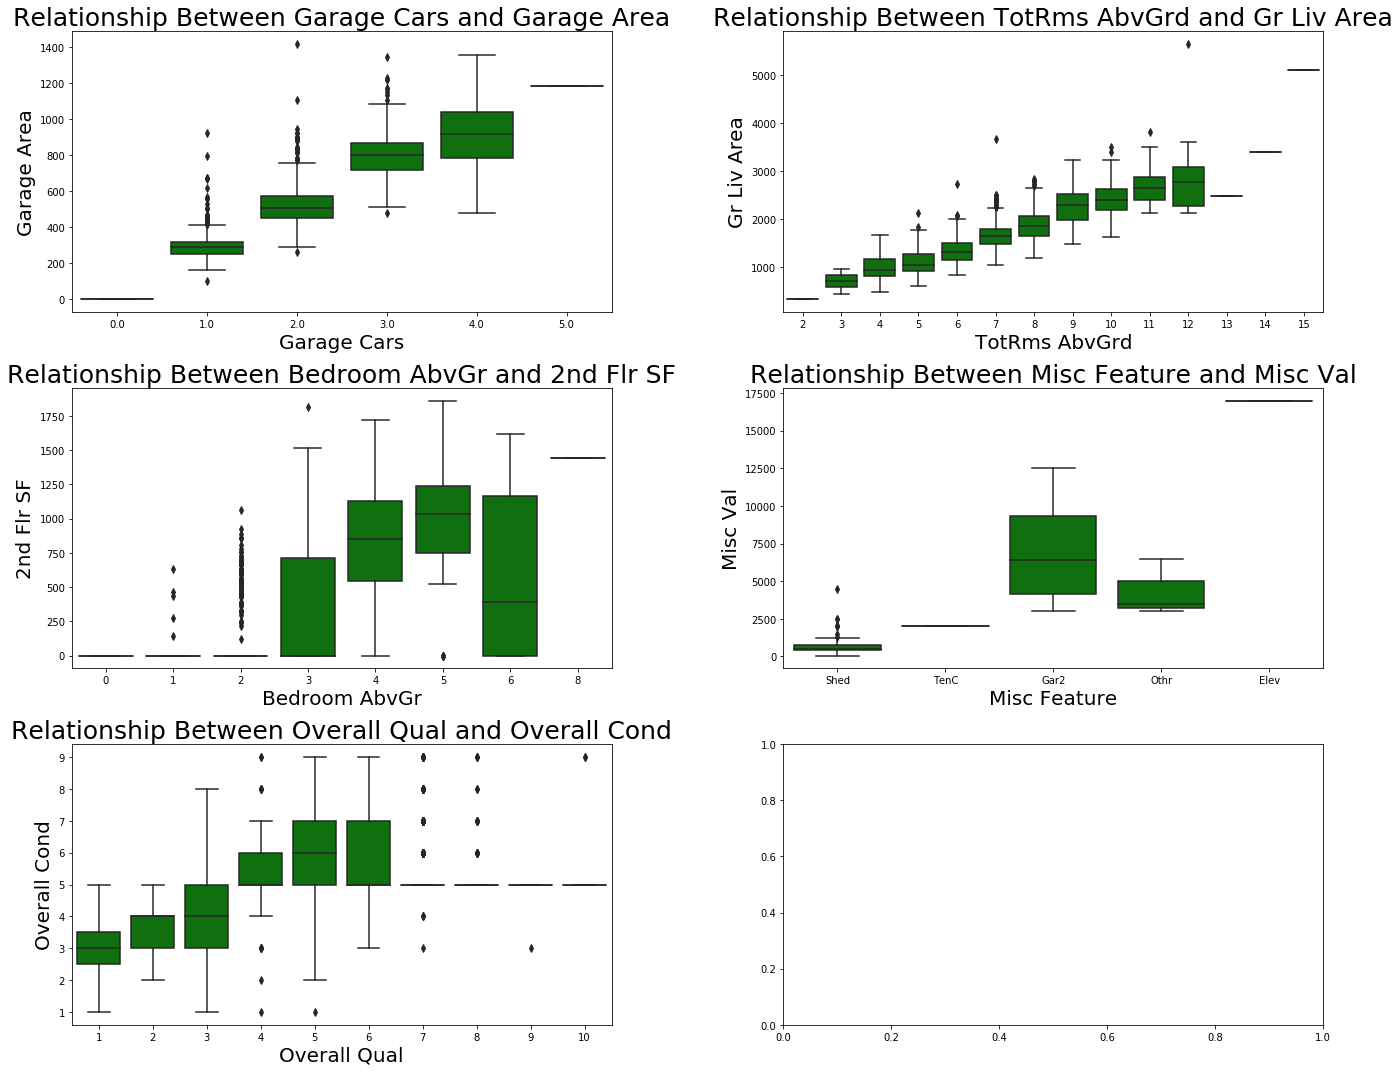

In [21]:
feat_dict={
    'Garage Cars':'Garage Area',
    'TotRms AbvGrd':'Gr Liv Area',
#     'Bsmt Baths':'BsmtFin SF 1',
    'Bedroom AbvGr':'2nd Flr SF',
    'Misc Feature':'Misc Val',
#     'Baths': 'TotRms AbvGrd',
    'Overall Qual':'Overall Cond',
}

subplot_boxplot(df, feat_dict, ncols=2)

Observations:

- Garage Cars / Garage Area: Strong linear relationship. May be best to use one or the other in modeling or consider an interaction feature.

- TotRms AbvGrd / Gr Liv Area: Strong linear relationship. May be best to use one or the other in modeling or consider an interaction feature. Can also consider dropping TotRms AbvGrd since already captured with Baths, Bedroom AbvGr, and Gr Liv Area.

- Bsmt Baths / BsmtFin SF 1: Strong linear relationship. 

- Bedroom AbvGr / 2nd Flr SF: Poor relationship. Largely independent.

- Misc feature / Misc Val: Poor correlation. 

- Baths / TotRms AbvGrd: Strongly related, which is not especially surprising as bathrooms are indeed rooms. 

- Overall Qual / Overall Cond: Poor correlation, should keep both since they encode different data.

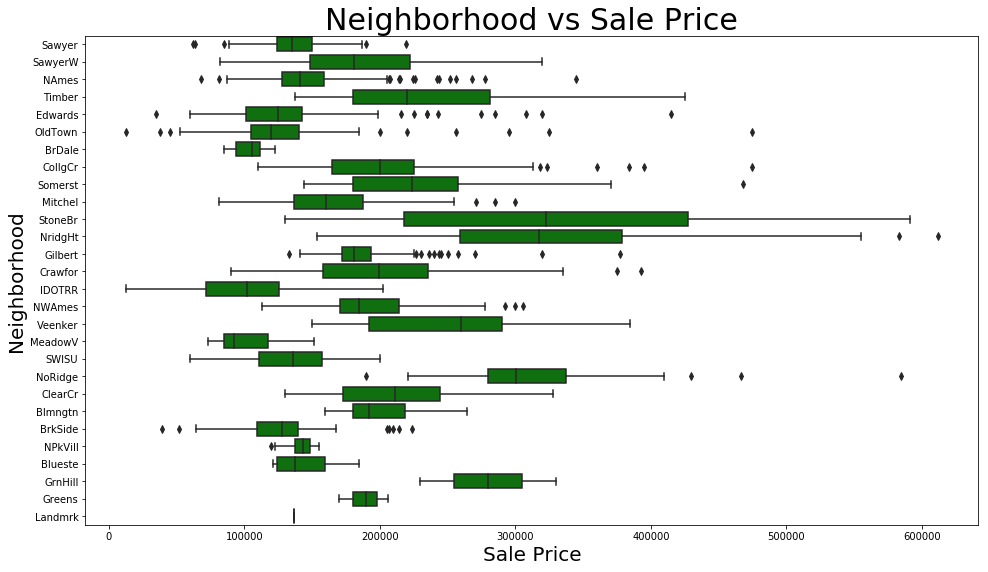

In [22]:
plt.figure(figsize=(16,9))
sns.boxplot(df['SalePrice'],df['Neighborhood'], orient='h', color = 'green')

plt.xlabel('Sale Price', fontsize=20)
plt.ylabel('Neighborhood', fontsize=20)
plt.title('Neighborhood vs Sale Price', fontsize=30);

Neighborhood seems to have a very large corrlation with sale price. 

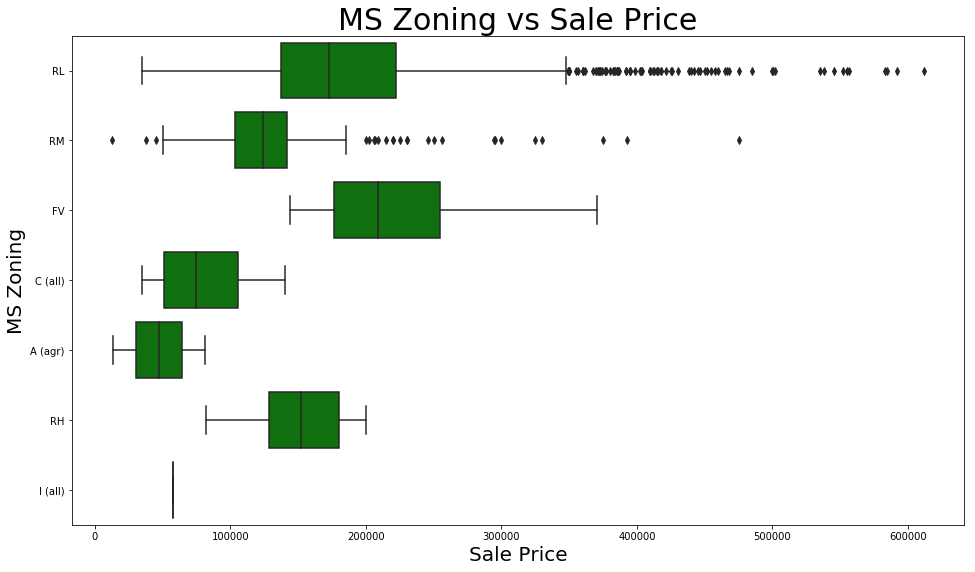

In [23]:
plt.figure(figsize=(16,9))
sns.boxplot(df['SalePrice'],df['MS Zoning'], orient='h', color = 'green')

plt.xlabel('Sale Price', fontsize=20)
plt.ylabel('MS Zoning', fontsize=20)
plt.title('MS Zoning vs Sale Price', fontsize=30);

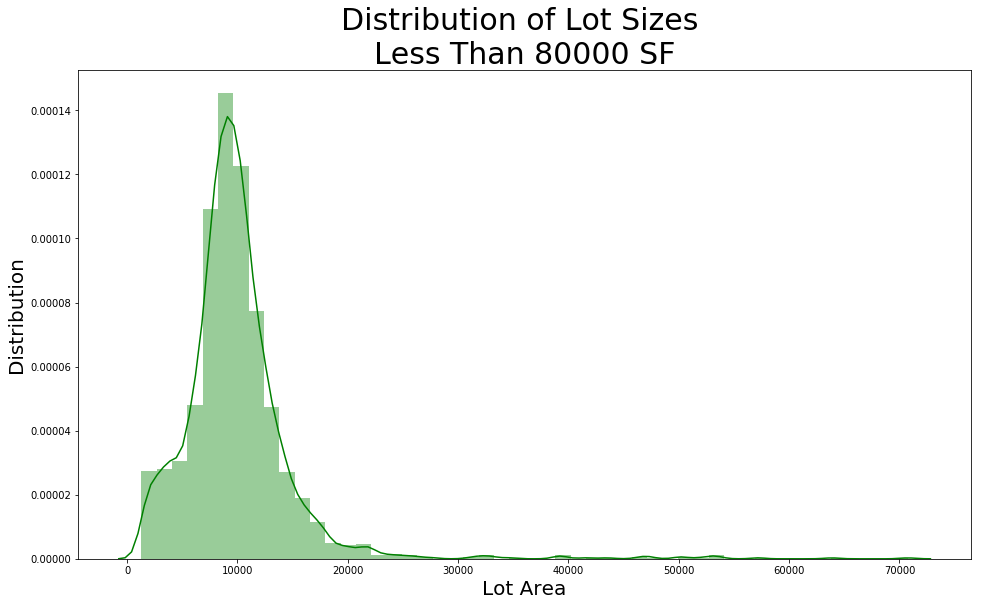

In [24]:
plt.figure(figsize=(16,9))
sns.distplot(df[df['Lot Area'].values < 80000]['Lot Area'], color = 'green')

plt.xlabel('Lot Area', fontsize=20)
plt.ylabel('Distribution', fontsize=20)
plt.title('Distribution of Lot Sizes \nLess Than 80000 SF', fontsize=30);

In [25]:
df.to_csv('../data/train_eda.csv', index_label='Id')

# Continue to NOTEBOOK 02: PREPROCESSING